In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


url = 'https://www.airlinequality.com/'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

reviews = soup.find_all('div', class_='review-selector')

airline_names = []
review_texts = []

for review in reviews:
    airline_name = review.find('h2', class_='review-heading').get_text(strip=True)
    review_text = review.find('div', class_='text_content').get_text(strip=True)

    airline_names.append(airline_name)
    review_texts.append(review_text)

reviews_df = pd.DataFrame({
    'Airline': airline_names,
    'Review': review_texts
})

reviews_df.to_csv('skytrax_reviews.csv', index=False)

print("Scraping complete. Data saved to skytrax_reviews.csv.")


Scraping complete. Data saved to skytrax_reviews.csv.


In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews into a single string
text = ' '.join(reviews_df['Review'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def extract_reviews(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    reviews = []
    for review in soup.find_all('article', class_='comp comp_review-entry'):
        rating = review.find('span', class_='star-rating').get('class')[1]
        rating_value = int(rating.replace('star-', '')) / 2  # Convert star-rating to decimal
        review_text = review.find('div', class_='text_content').text.strip()
        categories = {cat.find('span', class_='review-rating-header').text.strip(':'): len(cat.find_all('span', class_='star fill')) / 2
                      for cat in review.find_all('li', class_='comp comp_review-ratings')}

        reviews.append({
            'Rating': rating_value,
            'Review': review_text,
            **categories
        })

    return reviews
# !pip install xlsxwriter
def save_to_excel(data, filename):
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        for airline, reviews in data.items():
            df = pd.DataFrame(reviews)
            df.to_excel(writer, sheet_name=airline[:31], index=False)  # Sheet names must be <= 31 characters

# Example usage
urls = {
    'AB Aviation': 'https://www.airlinequality.com/airline-reviews/ab-aviation',
    'Air India': 'https://www.airlinequality.com/airline-reviews/air-india'
}

data = {airline: extract_reviews(url) for airline, url in urls.items()}
save_to_excel(data, 'airline_reviews.xlsx')
data


{'AB Aviation': [], 'Air India': []}

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the main A-Z airline reviews page
main_url = "https://www.airlinequality.com/review-pages/a-z-airline-reviews/"

# Function to get all airline review links
def get_airline_links(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    links = ["https://www.airlinequality.com" + a['href'] for a in soup.select(".azlisting a")]
    return links

# Function to extract reviews from an airline page
def extract_reviews(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    reviews = []
    categories = ["Review Text", "Rating", "Seat Comfort", "Cabin Staff Service", "Food & Beverages", "Ground Service", "Value for Money", "Recommended"]

    for review in soup.select(".review"):
        text = review.select_one(".text_content").get_text(strip=True) if review.select_one(".text_content") else ""
        rating = float(review.select_one(".rating-10 .rating").get_text(strip=True)) / 10 if review.select_one(".rating-10 .rating") else 0
        seat_comfort = int(review.select_one(".review-ratings .rating-1").get_text(strip=True)) if review.select_one(".review-ratings .rating-1") else 0
        cabin_staff_service = int(review.select_one(".review-ratings .rating-2").get_text(strip=True)) if review.select_one(".review-ratings .rating-2") else 0
        food_beverages = int(review.select_one(".review-ratings .rating-3").get_text(strip=True)) if review.select_one(".review-ratings .rating-3") else 0
        ground_service = int(review.select_one(".review-ratings .rating-4").get_text(strip=True)) if review.select_one(".review-ratings .rating-4") else 0
        value_for_money = int(review.select_one(".review-ratings .rating-5").get_text(strip=True)) if review.select_one(".review-ratings .rating-5") else 0
        recommended = review.select_one(".review-ratings .recommended").get_text(strip=True).lower() if review.select_one(".review-ratings .recommended") else "no"

        reviews.append({
            "Review Text": text,
            "Rating": rating,
            "Seat Comfort": seat_comfort,
            "Cabin Staff Service": cabin_staff_service,
            "Food & Beverages": food_beverages,
            "Ground Service": ground_service,
            "Value for Money": value_for_money,
            "Recommended": recommended
        })

    return pd.DataFrame(reviews, columns=categories)

# Get all airline review links
airline_links = get_airline_links(main_url)

# Create an Excel writer
writer = pd.ExcelWriter('Airline_Reviews.xlsx', engine='xlsxwriter')

# Loop through each airline link and extract reviews
for link in airline_links:
    airline_name = link.split("/")[-2].replace("-", " ").title()
    df_reviews = extract_reviews(link)
    df_reviews.to_excel(writer, sheet_name=airline_name[:31], index=False)

# Save the Excel file
writer.close()


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Fetch the webpage content
url = "https://www.airlinequality.com/airline-reviews/air-india"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find all reviews
reviews = soup.find_all('article', class_='comp_review')

# Extract data from reviews
data = []
for review in reviews:
    review_title = review.find('h2', class_='review-title').text.strip() if review.find('h2', class_='review-title') else ''
    review_rating = review.find('span', class_='rating-10').text.strip() if review.find('span', class_='rating-10') else ''
    review_date = review.find('time').text.strip() if review.find('time') else ''
    review_text = review.find('div', class_='text_content').text.strip() if review.find('div', class_='text_content') else ''

    # Extract additional categories
    traveller_type = review.find(text='Type Of Traveller').find_next('td').text.strip() if review.find(text='Type Of Traveller') else ''
    seat_type = review.find(text='Seat Type').find_next('td').text.strip() if review.find(text='Seat Type') else ''
    route = review.find(text='Route').find_next('td').text.strip() if review.find(text='Route') else ''
    date_flown = review.find(text='Date Flown').find_next('td').text.strip() if review.find(text='Date Flown') else ''
    seat_comfort = review.find(text='Seat Comfort').find_next('td').text.strip() if review.find(text='Seat Comfort') else ''
    cabin_service = review.find(text='Cabin Staff Service').find_next('td').text.strip() if review.find(text='Cabin Staff Service') else ''
    food_beverage = review.find(text='Food & Beverages').find_next('td').text.strip() if review.find(text='Food & Beverages') else ''
    inflight_entertainment = review.find(text='Inflight Entertainment').find_next('td').text.strip() if review.find(text='Inflight Entertainment') else ''
    ground_service = review.find(text='Ground Service').find_next('td').text.strip() if review.find(text='Ground Service') else ''
    wifi_connectivity = review.find(text='Wifi & Connectivity').find_next('td').text.strip() if review.find(text='Wifi & Connectivity') else ''
    value_for_money = review.find(text='Value For Money').find_next('td').text.strip() if review.find(text='Value For Money') else ''
    recommended = review.find(text='Recommended').find_next('td').text.strip() if review.find(text='Recommended') else ''

    data.append({
        'Title': review_title,
        'Rating': review_rating,
        'Date': review_date,
        'Review': review_text,
        'Type Of Traveller': traveller_type,
        'Seat Type': seat_type,
        'Route': route,
        'Date Flown': date_flown,
        'Seat Comfort': seat_comfort,
        'Cabin Staff Service': cabin_service,
        'Food & Beverages': food_beverage,
        'Inflight Entertainment': inflight_entertainment,
        'Ground Service': ground_service,
        'Wifi & Connectivity': wifi_connectivity,
        'Value For Money': value_for_money,
        'Recommended': recommended
    })

# Create a DataFrame
df = pd.DataFrame(data)

# Save DataFrame to Excel
df.head()


""


In [ ]:
import requests
from bs4 import BeautifulSoup

# URL of the webpage to scrape
url = 'https://www.airlinequality.com/airport-reviews/ahmedabad-airport/'

# Send a GET request to the webpage
response = requests.get(url)

# Parse the webpage content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all reviews on the page
reviews = soup.find_all('div', class_='body')

# Iterate through the reviews and extract details
for review in reviews:
    title = review.find('h2').get_text(strip=True)
    author = review.find('h3').get_text(strip=True)
    date = review.find('time').get_text(strip=True)
    content = review.find('div', class_='text_content').get_text(strip=True)
    rating = review.find('span', class_='rating-10').get_text(strip=True) if review.find('span', class_='rating-10') else 'N/A'

    print(f'Title: {title}')
    print(f'Author: {author}')
    print(f'Date: {date}')
    print(f'Content: {content}')
    print(f'Rating: {rating}')
    print('-' * 80)



Title: "Security staff at screening were rude"
Author: D Mantya(Australia)12th July 2024
Date: 12th July 2024
Content: ✅Trip Verified|  I used this airport for travelling on 11 Jul. The Internet did not connect for me as I don't have a local number - no Adani staff was around from security to any of the departure gates to ask the code. There is a land phone which was not working, sad to see in this condition.  immigration officers were laxed, 1 was on his mobile looking reels, 4 passengers were waiting, and he took off and went away without letting know. Security staff at screening were rude to elderly travelers who spoke Gujarati, this is Gujarat and not everyone needs to know Gujarati, but if some elders who can't speak in Hindi shouldn't be scolded or looked down on to speak Hindi. Every local country/region speaks their own language. If they are here to work from other states, they should be at least polite.
Rating: N/A
--------------------------------------------------------------

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def get_reviews_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = soup.find_all('div', class_='body')

    data = []
    for review in reviews:
        title = review.find('h2').get_text(strip=True)
        date = review.find('time').get_text(strip=True)
        content = review.find('div', class_='text_content').get_text(strip=True)

        data.append({
            'Title': title,
            'Date': date,
            'Content': content,
        })
    return data

def scrape_all_pages(base_url, num_pages):
    all_reviews = []
    for i in range(1, num_pages + 1):
        url = f'{base_url}page/{i}/'
        reviews = get_reviews_from_page(url)
        all_reviews.extend(reviews)
    return all_reviews

base_url = 'https://www.airlinequality.com/airport-reviews/ahmedabad-airport/'
num_pages = 5  # You can adjust the number of pages as needed

reviews_data = scrape_all_pages(base_url, num_pages)
df = pd.DataFrame(reviews_data)

# Display the DataFrame
print(df)

# Save to a CSV file
df.to_csv('ahmedabad_airport_reviews.csv', index=False)


                                                Title                 Date  \
0             "Security staff at screening were rude"       12th July 2024   
1                   "wheelchair facility is terrible"       20th June 2024   
2                          "Poor quality of services"     18th August 2023   
3                              "limit your time here"      24th April 2023   
4                   "Limited food and drinks options"   20th February 2023   
5                   "this is a great airport overall"   12th February 2023   
6                         "This airport is improving"    19th January 2023   
7                     "airport staff is very helpful"   17th December 2022   
8                "Airport with all basics facilities"    5th November 2022   
9                         "not much walking involved"    3rd November 2022   
10                        "Smooth arrival experience"    19th October 2022   
11                  "Sufficient seating arrangements"    19th Oc

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def get_reviews_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = soup.find_all('div', class_='body')

    data = []
    for review in reviews:
        title = review.find('h2').get_text(strip=True)
        date = review.find('time').get_text(strip=True)
        content = review.find('div', class_='text_content').get_text(strip=True)

        if 'Trip Verified' in content:
            trip_verified = 'Verified'
            content = content.replace('Trip Verified| ', '')
        else:
            trip_verified = 'Not Verified'
            content = content.replace('Not Verified| ', '')

        data.append({
            'Title': title,
            'Date': date,
            'Content': content,
            'Trip Verified': trip_verified
        })
    return data

def scrape_all_pages(base_url, num_pages):
    all_reviews = []
    for i in range(1, num_pages + 1):
        url = f'{base_url}page/{i}/'
        reviews = get_reviews_from_page(url)
        all_reviews.extend(reviews)
    return all_reviews

base_url = 'https://www.airlinequality.com/airport-reviews/ahmedabad-airport/'
num_pages = 5  # You can adjust the number of pages as needed

reviews_data = scrape_all_pages(base_url, num_pages)
df = pd.DataFrame(reviews_data)

# Display the DataFrame
print(df)

# Save to a CSV file
df.to_csv('ahmedabad_airport_reviews.csv', index=False)


                                                Title                 Date  \
0             "Security staff at screening were rude"       12th July 2024   
1                   "wheelchair facility is terrible"       20th June 2024   
2                          "Poor quality of services"     18th August 2023   
3                              "limit your time here"      24th April 2023   
4                   "Limited food and drinks options"   20th February 2023   
5                   "this is a great airport overall"   12th February 2023   
6                         "This airport is improving"    19th January 2023   
7                     "airport staff is very helpful"   17th December 2022   
8                "Airport with all basics facilities"    5th November 2022   
9                         "not much walking involved"    3rd November 2022   
10                        "Smooth arrival experience"    19th October 2022   
11                  "Sufficient seating arrangements"    19th Oc

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def extract_rating(review, category):
    category_header = review.find('td', class_=f'review-rating-header {category}')
    if category_header:
        stars_td = category_header.find_next_sibling('td', class_='review-rating-stars stars')
        filled_stars = stars_td.find_all('span', class_='star fill') if stars_td else []
        return len(filled_stars)
    return 'NA'

def get_reviews_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = soup.find_all('div', class_='body')

    data = []
    for review in reviews:
        title = review.find('h2').get_text(strip=True)
        date = review.find('time').get_text(strip=True)
        content = review.find('div', class_='text_content').get_text(strip=True)

        experience = review.find(string='Experience At Airport')
        experience = experience.find_next('td').get_text(strip=True) if experience else 'N/A'

        date_visit = review.find(string='Date Visit')
        date_visit = date_visit.find_next('td').get_text(strip=True) if date_visit else 'N/A'

        type_of_traveller = review.find(string='Type Of Traveller')
        type_of_traveller = type_of_traveller.find_next('td').get_text(strip=True) if type_of_traveller else 'N/A'

        queuing_times = extract_rating(review, 'queuing_times')
        terminal_cleanliness = extract_rating(review, 'terminal_cleanliness')
        terminal_seating = extract_rating(review, 'terminal_seating')
        terminal_signs = extract_rating(review, 'terminal_signs')
        food_beverages = extract_rating(review, 'food_beverages')
        airport_shopping = extract_rating(review, 'airport_shopping')
        wifi_connectivity = extract_rating(review, 'wifi_connectivity')
        airport_staff = extract_rating(review, 'airport_staff')

        recommended = review.find(string='Recommended')
        recommended = recommended.find_next('td').get_text(strip=True) if recommended else 'N/A'

        # Determine trip verification status
        if 'Trip Verified' in content:
            trip_verified = 'Verified'
            content = content.replace('✅Trip Verified| ', '')
        else:
            trip_verified = 'Not Verified'
            content = content.replace('Not Verified| ', '')
            content = content.replace('❎Not Verified|', '')

        if '✅Verified Review|' in content:
            trip_verified = 'Verified'
            content = content.replace('✅Verified Review|', '')

        data.append({
            'Title': title,
            'Date': date,
            'Content': content,
            'Trip Verified': trip_verified,
            'Experience At Airport': experience,
            'Date Visit': date_visit,
            'Type Of Traveller': type_of_traveller,
            'Queuing Times': queuing_times,
            'Terminal Cleanliness': terminal_cleanliness,
            'Terminal Seating': terminal_seating,
            'Terminal Signs': terminal_signs,
            'Food Beverages': food_beverages,
            'Airport Shopping': airport_shopping,
            'Wifi Connectivity': wifi_connectivity,
            'Airport Staff': airport_staff,
            'Recommended': recommended
        })
    return data

def scrape_all_pages(base_url, num_pages):
    all_reviews = []
    for i in range(1, num_pages + 1):
        url = f'{base_url}page/{i}/'
        reviews = get_reviews_from_page(url)
        all_reviews.extend(reviews)
    return all_reviews

base_url = 'https://www.airlinequality.com/airport-reviews/ahmedabad-airport/'
num_pages = 5  # You can adjust the number of pages as needed

# Extract airport name from the base URL
airport_name = base_url.split('/')[-2].replace('-', ' ').title()

reviews_data = scrape_all_pages(base_url, num_pages)
df = pd.DataFrame(reviews_data)

# Add the airport name column
df['Airport Name'] = airport_name

# Display the DataFrame
print(df)

# Save to a CSV file
df.to_csv('ahmedabad_airport_reviews.csv', index=False)


                                                Title                 Date  \
0             "Security staff at screening were rude"       12th July 2024   
1                   "wheelchair facility is terrible"       20th June 2024   
2                          "Poor quality of services"     18th August 2023   
3                              "limit your time here"      24th April 2023   
4                   "Limited food and drinks options"   20th February 2023   
5                   "this is a great airport overall"   12th February 2023   
6                         "This airport is improving"    19th January 2023   
7                     "airport staff is very helpful"   17th December 2022   
8                "Airport with all basics facilities"    5th November 2022   
9                         "not much walking involved"    3rd November 2022   
10                        "Smooth arrival experience"    19th October 2022   
11                  "Sufficient seating arrangements"    19th Oc

In [ ]:
ascii('✅')

"'\\u2705'"

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def extract_rating(review, category):
    try:
        category_header = review.find('td', class_=f'review-rating-header {category}')
        if category_header:
            stars_td = category_header.find_next_sibling('td', class_='review-rating-stars stars')
            filled_stars = stars_td.find_all('span', class_='star fill') if stars_td else []
            return len(filled_stars)
    except Exception as e:
        print(f"Error extracting rating for category '{category}': {e}")
    return 'NA'

def get_reviews_from_page(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        reviews = soup.find_all('div', class_='body')

        if not reviews:
            print(f"No reviews found on page: {url}")
            return []

        data = []
        for review in reviews:
            try:
                title = review.find('h2').get_text(strip=True)
                date = review.find('time').get_text(strip=True)
                content = review.find('div', class_='text_content').get_text(strip=True)

                experience = review.find(string='Experience At Airport')
                experience = experience.find_next('td').get_text(strip=True) if experience else 'N/A'

                date_visit = review.find(string='Date Visit')
                date_visit = date_visit.find_next('td').get_text(strip=True) if date_visit else 'N/A'

                type_of_traveller = review.find(string='Type Of Traveller')
                type_of_traveller = type_of_traveller.find_next('td').get_text(strip=True) if type_of_traveller else 'N/A'

                queuing_times = extract_rating(review, 'queuing_times')
                terminal_cleanliness = extract_rating(review, 'terminal_cleanliness')
                terminal_seating = extract_rating(review, 'terminal_seating')
                terminal_signs = extract_rating(review, 'terminal_signs')
                food_beverages = extract_rating(review, 'food_beverages')
                airport_shopping = extract_rating(review, 'airport_shopping')
                wifi_connectivity = extract_rating(review, 'wifi_connectivity')
                airport_staff = extract_rating(review, 'airport_staff')

                recommended = review.find(string='Recommended')
                recommended = recommended.find_next('td').get_text(strip=True) if recommended else 'N/A'

                # Determine trip verification status
                if 'Trip Verified' in content:
                    trip_verified = 'Verified'
                    content = content.replace('✅Trip Verified| ', '')
                else:
                    trip_verified = 'Not Verified'
                    content = content.replace('Not Verified| ', '')
                    content = content.replace('❎Not Verified|', '')

                if '✅Verified Review|' in content:
                    trip_verified = 'Verified'
                    content = content.replace('✅Verified Review|', '')

                data.append({
                    'Title': title,
                    'Date': date,
                    'Content': content,
                    'Trip Verified': trip_verified,
                    'Experience At Airport': experience,
                    'Date Visit': date_visit,
                    'Type Of Traveller': type_of_traveller,
                    'Queuing Times': queuing_times,
                    'Terminal Cleanliness': terminal_cleanliness,
                    'Terminal Seating': terminal_seating,
                    'Terminal Signs': terminal_signs,
                    'Food Beverages': food_beverages,
                    'Airport Shopping': airport_shopping,
                    'Wifi Connectivity': wifi_connectivity,
                    'Airport Staff': airport_staff,
                    'Recommended': recommended
                })
            except Exception as e:
                print(f"Error processing review: {e}")
        return data
    except Exception as e:
        print(f"Error fetching URL '{url}': {e}")
        return []

def get_total_pages(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        pagination = soup.find('div', class_='pagination')
        if pagination:
            last_page_link = pagination.find_all('a')[-1].get('href')
            if last_page_link:
                last_page_number = int(last_page_link.split('/')[-2])
                return last_page_number
    except Exception as e:
        print(f"Error fetching total pages for URL '{url}': {e}")
    return 1

def scrape_all_pages(base_url, num_pages=None):
    if num_pages is None:
        num_pages = get_total_pages(base_url)

    all_reviews = []
    for i in range(1, num_pages + 1):
        url = f'{base_url}page/{i}/'
        print(f"Scraping {url}")
        reviews = get_reviews_from_page(url)
        if reviews:
            all_reviews.extend(reviews)
        else:
            print(f"No reviews found or error scraping page {i}")
        time.sleep(1)  # Add delay to avoid overwhelming the server
    return all_reviews

def compile_reviews(excel_path, output_path, num_pages=None):
    # Read the Excel file
    df_airports = pd.read_excel(excel_path, sheet_name='Table 2 (2)')

    all_reviews = []

    # Iterate through each airport's link
    for index, row in df_airports.iterrows():
        airport_name = row['Airport Names']
        base_url = row['Open Review link of that airport']

        print(f"Scraping reviews for {airport_name} from {base_url}")
        reviews_data = scrape_all_pages(base_url, num_pages)

        # Add the airport name to each review
        for review in reviews_data:
            review['Airport Name'] = airport_name

        all_reviews.extend(reviews_data)

    # Create a DataFrame from all reviews
    df_reviews = pd.DataFrame(all_reviews)

    # Save to a new Excel file
    df_reviews.to_excel(output_path, index=False)

# Path to the Excel file containing the airport names and links
excel_path = '/content/Airports Reviews project.xlsx'  # Replace this with the actual file path
output_path = 'all_airport_reviews.xlsx'  # Output file path

# Compile reviews into a single Excel file
compile_reviews(excel_path, output_path, num_pages=None)


Scraping reviews for Aalborg from https://www.airlinequality.com/airport-reviews/aalborg-airport/
Scraping https://www.airlinequality.com/airport-reviews/aalborg-airport/page/1/
Scraping reviews for Aarhus from https://www.airlinequality.com/airport-reviews/aarhus-airport/
Scraping https://www.airlinequality.com/airport-reviews/aarhus-airport/page/1/
Scraping reviews for Abbotsford Intl from https://www.airlinequality.com/airport-reviews/abbotsford-intl-airport/
Scraping https://www.airlinequality.com/airport-reviews/abbotsford-intl-airport/page/1/
Scraping reviews for Aberdeen from https://www.airlinequality.com/airport-reviews/aberdeen-airport/
Scraping https://www.airlinequality.com/airport-reviews/aberdeen-airport/page/1/
Scraping reviews for Abidjan from https://www.airlinequality.com/airport-reviews/abidjan-airport/
Scraping https://www.airlinequality.com/airport-reviews/abidjan-airport/page/1/
Scraping reviews for Abu Dhabi from https://www.airlinequality.com/airport-reviews/abu

In [ ]:
# prompt: # Drop all columns except 'Title' , 'Content' , 'Recommended'  and perform an NLP

# Drop unnecessary columns
import pandas as pd
df=pd.read_excel('/content/all_airport_reviews (1).xlsx')
# Assuming df is your DataFrame
df_nlp = df[['Title', 'Content', 'Recommended']]

# Perform NLP tasks here
# Example: Sentiment analysis using TextBlob
from textblob import TextBlob

# Calculate sentiment polarity for each review
df_nlp['Sentiment'] = df_nlp['Content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Print the updated DataFrame
print(df_nlp)


                                        Title  \
0                "airport is always a breeze"   
1             "most chaotic airport transfer"   
2        "never any significant waiting time"   
3      "Better signs and maybe announcements"   
4            "a small very effective airport"   
...                                       ...   
5767     "Extremely disappointing experience"   
5768                   "Overall satisfactory"   
5769              "Total joke Zürich Airport"   
5770  "Information staff were extremely rude"   
5771                “ground team cannot cope”   

                                                Content Recommended  Sentiment  
0      This airport is always a breeze. Small and co...         yes  -0.010641  
1      Worst and most chaotic airport transfer I hav...          no  -0.040000  
2     The best airport in the world. I have used it ...         yes   0.415000  
3       The baggage claim areas have obviously been ...         yes  -0.027778  
4     

<ipython-input-2-1723e18f3da0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp['Sentiment'] = df_nlp['Content'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def extract_rating(review, category):
    category_header = review.find('td', class_=f'review-rating-header {category}')
    if category_header:
        stars_td = category_header.find_next_sibling('td', class_='review-rating-stars stars')
        filled_stars = stars_td.find_all('span', class_='star fill') if stars_td else []
        return len(filled_stars)
    return 'NA'

def get_reviews_from_page(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        reviews = soup.find_all('div', class_='body')

        data = []
        for review in reviews:
            try:
                title = review.find('h2').get_text(strip=True)
                date = review.find('time').get_text(strip=True)
                content = review.find('div', class_='text_content').get_text(strip=True)

                experience = review.find(string='Experience At Airport')
                experience = experience.find_next('td').get_text(strip=True) if experience else 'N/A'

                date_visit = review.find(string='Date Visit')
                date_visit = date_visit.find_next('td').get_text(strip=True) if date_visit else 'N/A'

                type_of_traveller = review.find(string='Type Of Traveller')
                type_of_traveller = type_of_traveller.find_next('td').get_text(strip=True) if type_of_traveller else 'N/A'

                queuing_times = extract_rating(review, 'queuing_times')
                terminal_cleanliness = extract_rating(review, 'terminal_cleanliness')
                terminal_seating = extract_rating(review, 'terminal_seating')
                terminal_signs = extract_rating(review, 'terminal_signs')
                food_beverages = extract_rating(review, 'food_beverages')
                airport_shopping = extract_rating(review, 'airport_shopping')
                wifi_connectivity = extract_rating(review, 'wifi_connectivity')
                airport_staff = extract_rating(review, 'airport_staff')

                recommended = review.find(string='Recommended')
                recommended = recommended.find_next('td').get_text(strip=True) if recommended else 'N/A'

                # Determine trip verification status
                if 'Trip Verified' in content:
                    trip_verified = 'Verified'
                    content = content.replace('✅Trip Verified| ', '')
                else:
                    trip_verified = 'Not Verified'
                    content = content.replace('Not Verified| ', '')
                    content = content.replace('❎Not Verified|', '')

                if '✅Verified Review|' in content:
                    trip_verified = 'Verified'
                    content = content.replace('✅Verified Review|', '')

                data.append({
                    'Title': title,
                    'Date': date,
                    'Content': content,
                    'Trip Verified': trip_verified,
                    'Experience At Airport': experience,
                    'Date Visit': date_visit,
                    'Type Of Traveller': type_of_traveller,
                    'Queuing Times': queuing_times,
                    'Terminal Cleanliness': terminal_cleanliness,
                    'Terminal Seating': terminal_seating,
                    'Terminal Signs': terminal_signs,
                    'Food Beverages': food_beverages,
                    'Airport Shopping': airport_shopping,
                    'Wifi Connectivity': wifi_connectivity,
                    'Airport Staff': airport_staff,
                    'Recommended': recommended
                })
            except Exception as e:
                print(f"Error processing a review: {e}")
        return data
    except Exception as e:
        print(f"Error fetching URL '{url}': {e}")
        return []

def scrape_all_pages(base_url, max_pages=100):
    all_reviews = []
    for i in range(1, max_pages + 1):
        url = f'{base_url}page/{i}/'
        print(f"Scraping {url}")
        try:
            reviews = get_reviews_from_page(url)
            if not reviews:
                break  # If no reviews are found, stop fetching more pages
            all_reviews.extend(reviews)
            # time.sleep(1)  # Add delay to avoid overwhelming the server
        except requests.exceptions.RequestException as e:
            print(f"Error fetching page {i}: {e}. Moving to the next airport.")
            break
    return all_reviews

def compile_reviews(excel_path, output_path, max_pages=100):
    df_airports = pd.read_excel(excel_path, sheet_name='Table 2 (2)')

    all_reviews = []

    for index, row in df_airports.iterrows():
        airport_name = row['Airport Names']
        base_url = row['Open Review link of that airport']

        print(f"Scraping reviews for {airport_name} from {base_url}")

        reviews_data = scrape_all_pages(base_url, max_pages)

        for review in reviews_data:
            review['Airport Name'] = airport_name

        all_reviews.extend(reviews_data)

    df_reviews = pd.DataFrame(all_reviews)
    df_reviews.to_excel(output_path, index=False)

# Path to the Excel file containing the airport names and links
excel_path = '/content/Airports Reviews (1).xlsx'  # Replace this with the actual file path
output_path = 'all_airport_reviews.xlsx'  # Output file path

# Compile reviews into a single Excel file
compile_reviews(excel_path, output_path, max_pages=100)


Streaming output truncated to the last 5000 lines.
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/42/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/43/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/44/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/45/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/46/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/47/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/48/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/49/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/50/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/51/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/52/
Scraping https://www.airlinequality.com/airport-reviews/dubai-airport/page/53/
S

In [ ]:
import pandas as pd
import numpy as np

df=pd.read_excel('/content/all_airport_reviews (2).xlsx')
df.head()

,Title,Date,Content,Trip Verified,Experience At Airport,Date Visit,Type Of Traveller,Queuing Times,Terminal Cleanliness,Terminal Seating,Terminal Signs,Food Beverages,Airport Shopping,Wifi Connectivity,Airport Staff,Recommended,Airport Name
0,"""airport is always a breeze""",16th September 2023,This airport is always a breeze. Small and co...,Not Verified,Arrival and Departure,September 2023,Solo Leisure,5.0,4.0,3.0,5.0,3.0,NaN,5.0,4.0,yes,Aalborg
1,"""most chaotic airport transfer""",6th January 2019,Worst and most chaotic airport transfer I hav...,Not Verified,Transit,January 2019,Family Leisure,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no,Aalborg
2,"""never any significant waiting time""",7th June 2018,The best airport in the world. I have used it ...,Verified,Arrival and Departure,May 2018,Solo Leisure,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,yes,Aalborg
3,"""Better signs and maybe announcements""",19th March 2017,The baggage claim areas have obviously been ...,Verified,Arrival Only,February 2017,Solo Leisure,3.0,5.0,NaN,1.0,NaN,NaN,NaN,5.0,yes,Aalborg
4,"""a small very effective airport""",11th February 2014,A small very effective airport with few flight...,Not Verified,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,4.0,NaN,NaN,yes,Aalborg


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43988 entries, 0 to 43987
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title                  43988 non-null  object 
 1   Date                   43988 non-null  object 
 2   Content                43988 non-null  object 
 3   Trip Verified          43988 non-null  object 
 4   Experience At Airport  27943 non-null  object 
 5   Date Visit             27878 non-null  object 
 6   Type Of Traveller      27921 non-null  object 
 7   Queuing Times          39312 non-null  float64
 8   Terminal Cleanliness   39298 non-null  float64
 9   Terminal Seating       24373 non-null  float64
 10  Terminal Signs         27321 non-null  float64
 11  Food Beverages         27630 non-null  float64
 12  Airport Shopping       31690 non-null  float64
 13  Wifi Connectivity      18898 non-null  float64
 14  Airport Staff          25528 non-null  float64
 15  Re

In [ ]:
df.shape

(43988, 17)

In [ ]:
df.describe()


In [ ]:
# 7   Queuing Times          39312 non-null  float64
#  8   Terminal Cleanliness   39298 non-null  float64

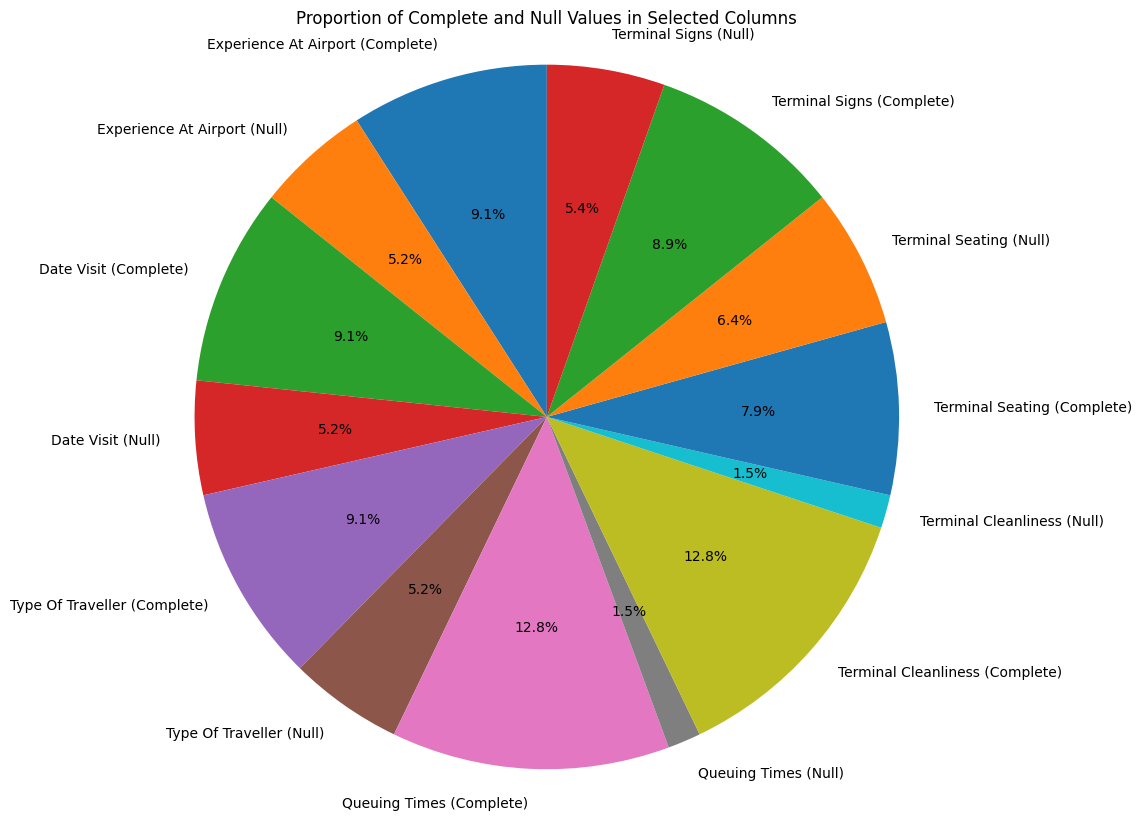

In [ ]:



# Calculate the number of null and non-null values for each column
null_counts = df[['Experience At Airport', 'Date Visit', 'Type Of Traveller', 'Queuing Times',
                   'Terminal Cleanliness', 'Terminal Seating', 'Terminal Signs']].isnull().sum()
non_null_counts = df[['Experience At Airport', 'Date Visit', 'Type Of Traveller', 'Queuing Times',
                     'Terminal Cleanliness', 'Terminal Seating', 'Terminal Signs']].notnull().sum()

# Create labels and data for the pie chart
labels = ['Experience At Airport (Complete)', 'Experience At Airport (Null)',
           'Date Visit (Complete)', 'Date Visit (Null)',
           'Type Of Traveller (Complete)', 'Type Of Traveller (Null)',
           'Queuing Times (Complete)', 'Queuing Times (Null)',
           'Terminal Cleanliness (Complete)', 'Terminal Cleanliness (Null)',
           'Terminal Seating (Complete)', 'Terminal Seating (Null)',
           'Terminal Signs (Complete)', 'Terminal Signs (Null)']

sizes = [non_null_counts['Experience At Airport'], null_counts['Experience At Airport'],
         non_null_counts['Date Visit'], null_counts['Date Visit'],
         non_null_counts['Type Of Traveller'], null_counts['Type Of Traveller'],
         non_null_counts['Queuing Times'], null_counts['Queuing Times'],
         non_null_counts['Terminal Cleanliness'], null_counts['Terminal Cleanliness'],
         non_null_counts['Terminal Seating'], null_counts['Terminal Seating'],
         non_null_counts['Terminal Signs'], null_counts['Terminal Signs']]

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Proportion of Complete and Null Values in Selected Columns')
plt.show()


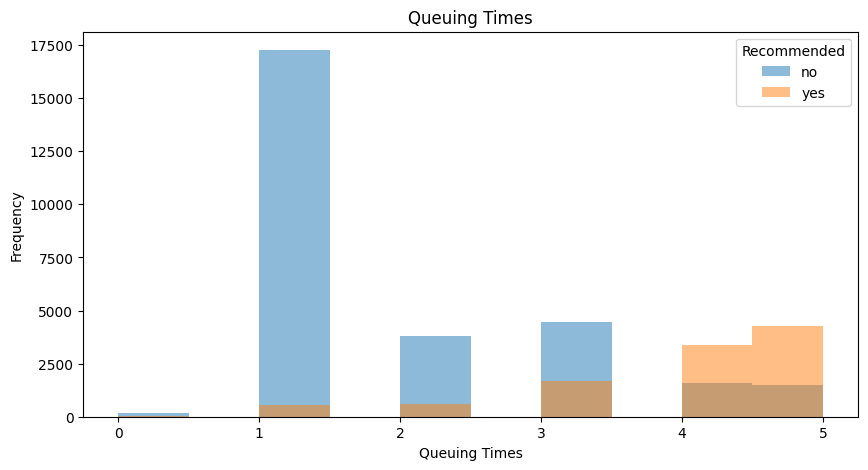

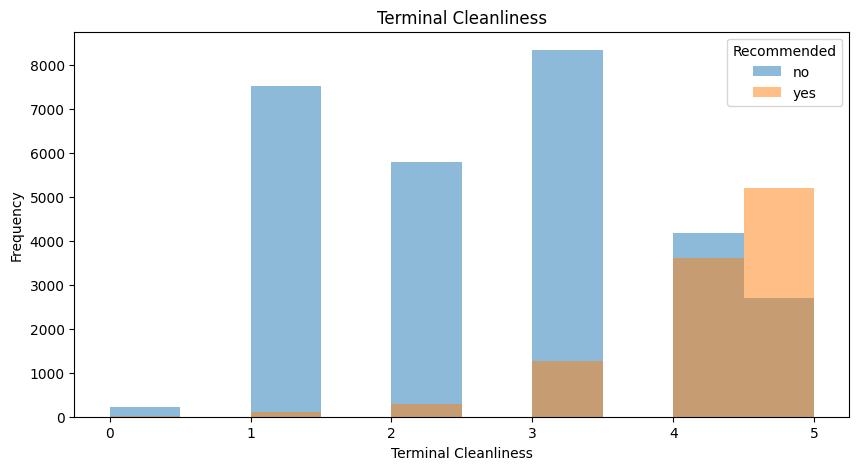

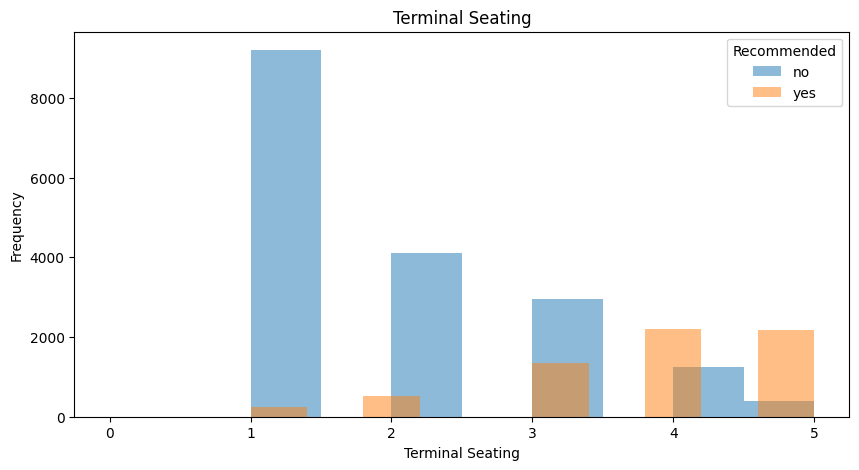

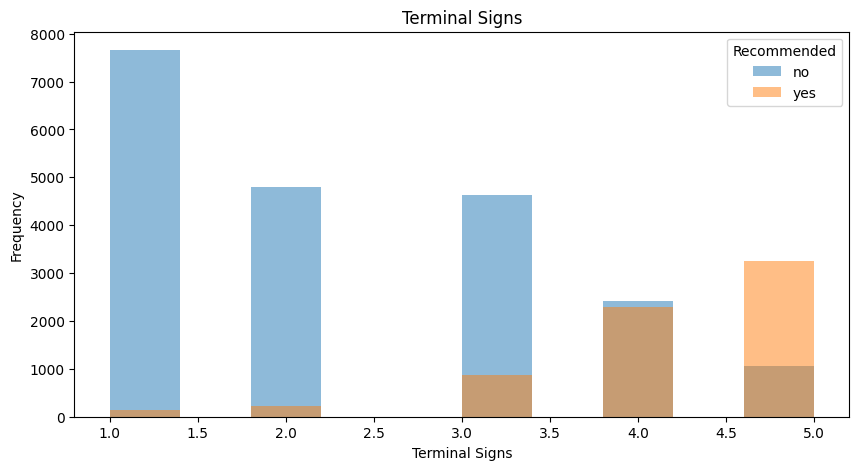

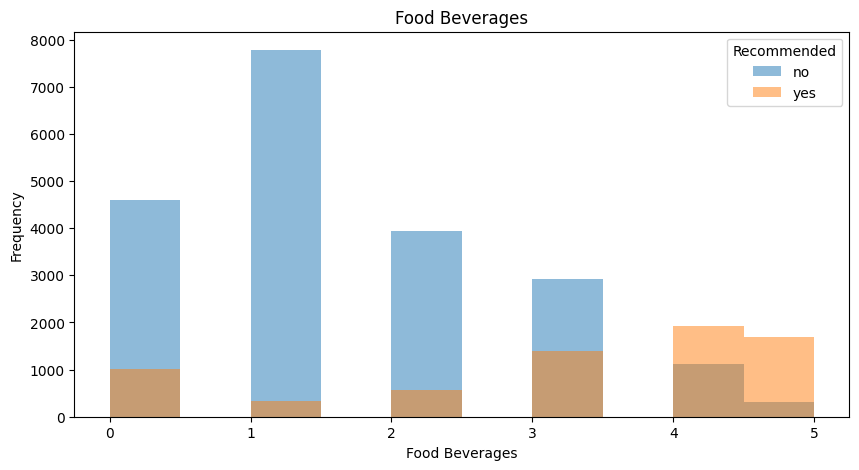

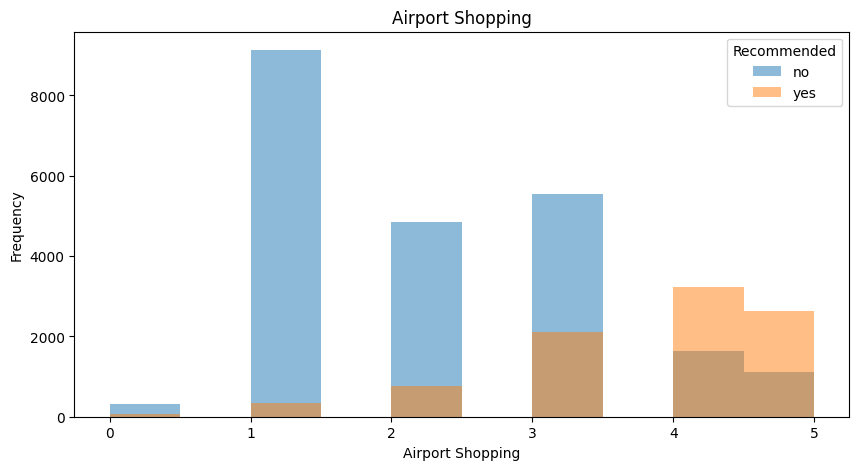

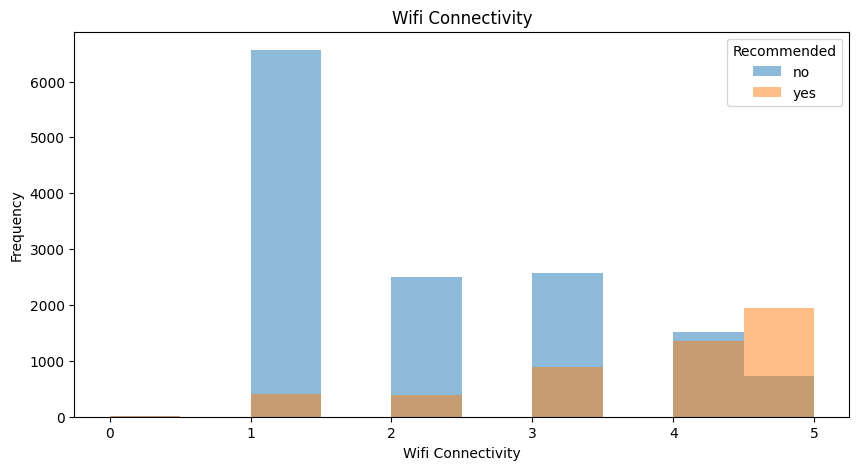

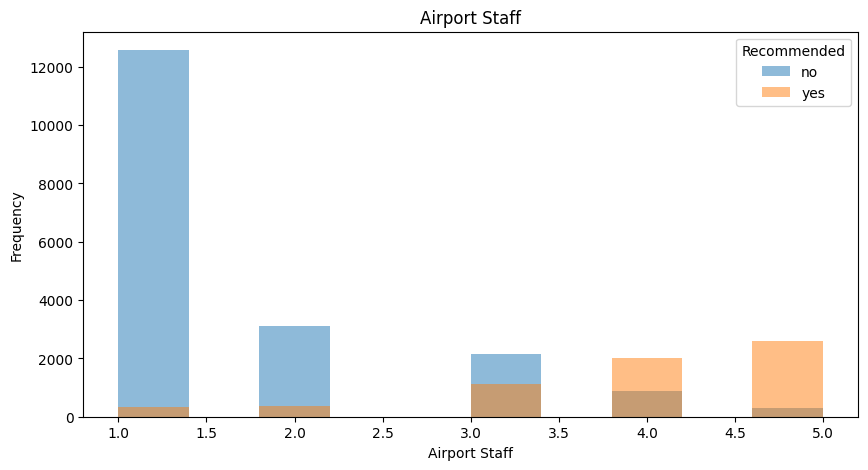

In [ ]:
parameters = ["Queuing Times", "Terminal Cleanliness", "Terminal Seating", "Terminal Signs",
              "Food Beverages", "Airport Shopping", "Wifi Connectivity", "Airport Staff"]

for param in parameters:
    plt.figure(figsize=(10, 5))
    df_non_null = df[df[param].notnull()]
    df_non_null.groupby('Recommended')[param].plot(kind='hist', alpha=0.5, legend=True, title=param)
    plt.xlabel(param)
    plt.ylabel('Frequency')
    plt.legend(title='Recommended')
    plt.show()




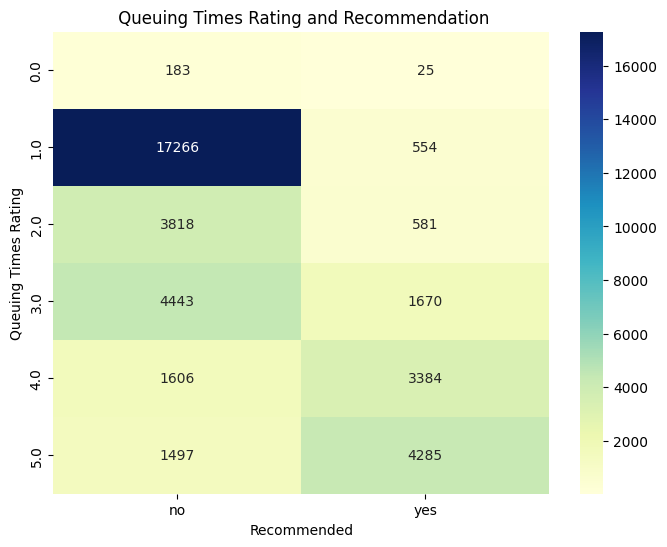

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
queue_recommended_crosstab = pd.crosstab(df['Queuing Times'], df['Recommended'])

plt.figure(figsize=(8, 6))
sns.heatmap(queue_recommended_crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title(" Queuing Times Rating and Recommendation")
plt.xlabel("Recommended")
plt.ylabel("Queuing Times Rating")
plt.show()


In [ ]:
df['Type Of Traveller'].unique()


array(['Solo Leisure', 'Family Leisure', nan, 'Business',
       'Couple Leisure'], dtype=object)

In [ ]:
df2=df.dropna(subset=['Type Of Traveller'])
df2.head()

,Title,Date,Content,Trip Verified,Experience At Airport,Date Visit,Type Of Traveller,Queuing Times,Terminal Cleanliness,Terminal Seating,Terminal Signs,Food Beverages,Airport Shopping,Wifi Connectivity,Airport Staff,Recommended,Airport Name
0,"""airport is always a breeze""",16th September 2023,This airport is always a breeze. Small and co...,Not Verified,Arrival and Departure,September 2023,Solo Leisure,5.0,4.0,3.0,5.0,3.0,NaN,5.0,4.0,yes,Aalborg
1,"""most chaotic airport transfer""",6th January 2019,Worst and most chaotic airport transfer I hav...,Not Verified,Transit,January 2019,Family Leisure,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no,Aalborg
2,"""never any significant waiting time""",7th June 2018,The best airport in the world. I have used it ...,Verified,Arrival and Departure,May 2018,Solo Leisure,5.0,5.0,5.0,5.0,0.0,5.0,5.0,5.0,yes,Aalborg
3,"""Better signs and maybe announcements""",19th March 2017,The baggage claim areas have obviously been ...,Verified,Arrival Only,February 2017,Solo Leisure,3.0,5.0,NaN,1.0,NaN,NaN,NaN,5.0,yes,Aalborg
14,"""miserable place with very few facilities""",3rd March 2017,This place is a dump. Miserable place with ver...,Not Verified,Departure Only,March 2017,Solo Leisure,3.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0,no,Aarhus


<ipython-input-19-8e54a0fab71d>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['YEAR'] = pd.to_datetime(df2['Date Visit']).dt.year
<ipython-input-19-8e54a0fab71d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['YEAR'] = pd.to_datetime(df2['Date Visit']).dt.year


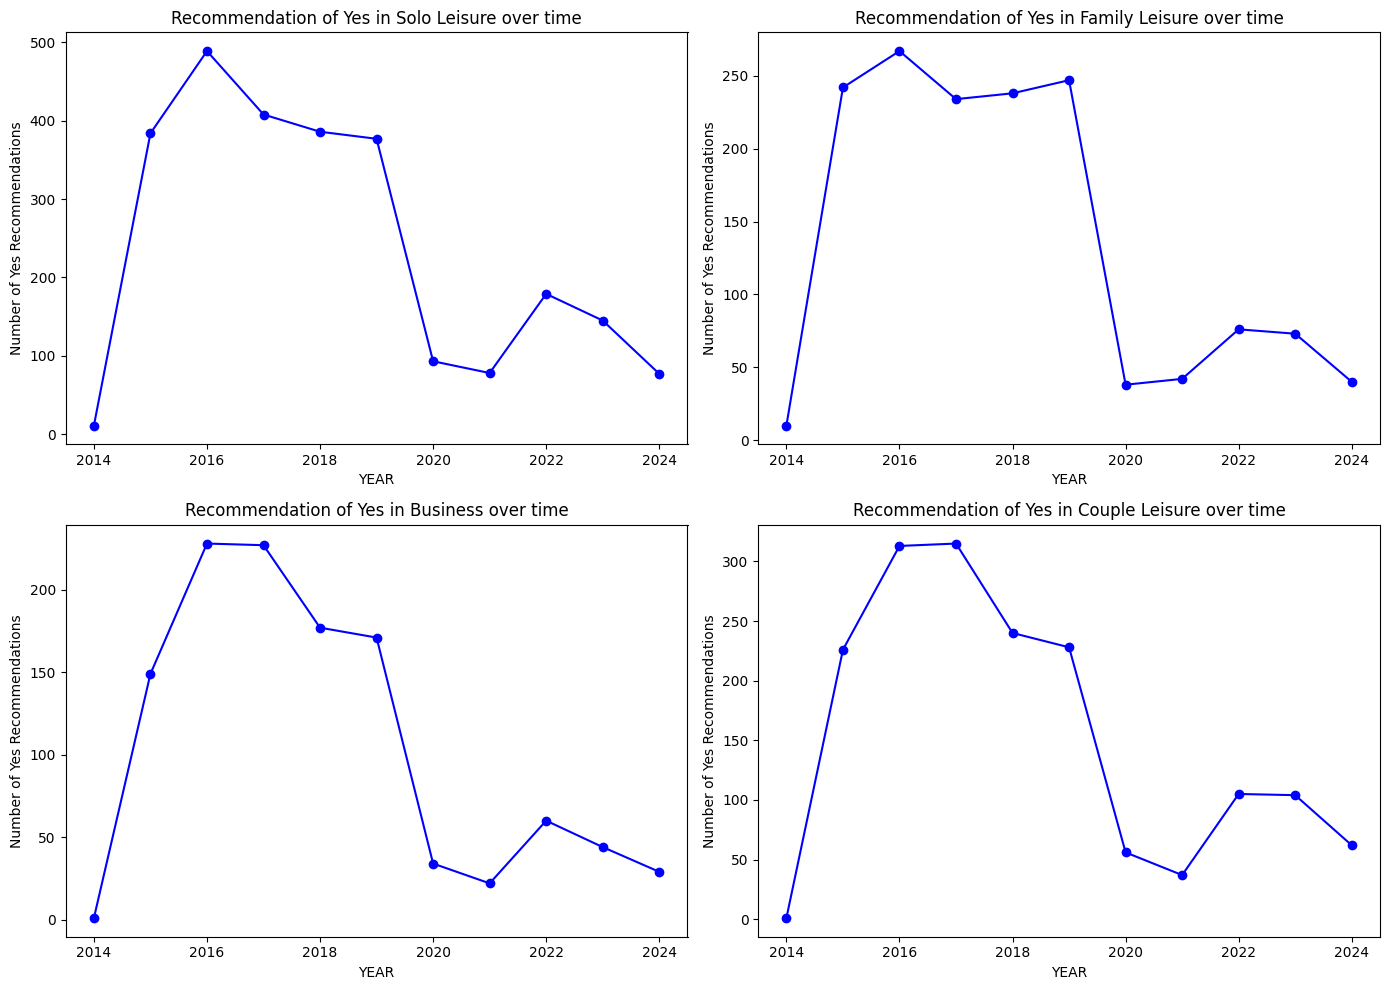

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df2['YEAR'] = pd.to_datetime(df2['Date Visit']).dt.year

traveller_types = df2['Type Of Traveller'].unique()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, traveller_type in enumerate(traveller_types):
    df_traveller = df2[df2['Type Of Traveller'] == traveller_type]
    df_traveller_yes = df_traveller[df_traveller['Recommended'] == 'yes']

    yearly_counts = df_traveller_yes.groupby('YEAR')['Recommended'].count()

    ax = axes[i]
    ax.plot(yearly_counts.index, yearly_counts.values, marker='o', color='b')
    ax.set_title(f'Recommendation of Yes in {traveller_type} over time')
    ax.set_xlabel('YEAR')
    ax.set_ylabel('Number of Yes Recommendations')

plt.tight_layout()
plt.show()


In [ ]:
!pip install ipywidgets




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.7 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from IPython.display import display


In [ ]:

categories = ["Queuing Times", "Terminal Cleanliness", "Terminal Seating", "Terminal Signs", "Food Beverages", "Airport Shopping", "Wifi Connectivity", "Airport Staff"]


dropdown = widgets.Dropdown(
    options=categories,
    value=categories[0],
    description='Categories:',
    disabled=False,
)


display(dropdown)


df = pd.read_excel('/content/all_airport_reviews (2).xlsx')

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_categories = [change['new']]  # Get the selected category
        process_data(selected_categories)

dropdown.observe(on_change)

def process_data(selected_categories):
    selected_categories = [cat.strip() for cat in selected_categories[0].split(',')]
    airport_counts = df['Airport Name'].value_counts()
    valid_airports = airport_counts[airport_counts >= 20].index.tolist()
    df_filtered = df[df['Airport Name'].isin(valid_airports)]
    df_filtered[selected_categories] = df_filtered.groupby('Airport Name')[selected_categories].transform(lambda x: x.fillna(x.mean()))


    average_ratings = df_filtered.groupby('Airport Name')[selected_categories].mean()


    if len(selected_categories) > 1:
        average_ratings['Overall Average'] = average_ratings.mean(axis=1)
        sort_column = 'Overall Average'
    else:
        sort_column = selected_categories[0]


    top_airports = average_ratings.sort_values(by=sort_column, ascending=False)


    top_airports.to_csv('top_airports.csv')

    print("Top airports in the selected categories have been saved to 'top_airports.csv'")


process_data([dropdown.value])


Dropdown(description='Categories:', options=('Queuing Times', 'Terminal Cleanliness', 'Terminal Seating', 'Ter…

Top airports in the selected categories have been saved to 'top_airports.csv'


<ipython-input-4-bfc55ee6f669>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[selected_categories] = df_filtered.groupby('Airport Name')[selected_categories].transform(lambda x: x.fillna(x.mean()))


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display


categories = ["Queuing Times", "Terminal Cleanliness", "Terminal Seating", "Terminal Signs", "Food Beverages", "Airport Shopping", "Wifi Connectivity", "Airport Staff"]

checkboxes = [widgets.Checkbox(value=False, description=cat) for cat in categories]
process_button = widgets.Button(description="Process Selected Categories")
display(*checkboxes)
display(process_button)

df = pd.read_excel('/content/all_airport_reviews (2).xlsx')

def get_selected_categories():
    """Get the selected categories from the checkboxes."""
    return [checkbox.description for checkbox in checkboxes if checkbox.value]

def process_data(selected_categories):
    selected_categories = [cat.strip() for cat in selected_categories]
    airport_counts = df['Airport Name'].value_counts()
    valid_airports = airport_counts[airport_counts >= 20].index.tolist()
    df_filtered = df[df['Airport Name'].isin(valid_airports)]
    df_filtered[selected_categories] = df_filtered.groupby('Airport Name')[selected_categories].transform(lambda x: x.fillna(x.mean()))

    average_ratings = df_filtered.groupby('Airport Name')[selected_categories].mean()

    if len(selected_categories) > 1:
        average_ratings['Overall Average'] = average_ratings.mean(axis=1)
        sort_column = 'Overall Average'
    else:
        sort_column = selected_categories[0]

    top_airports = average_ratings.sort_values(by=sort_column, ascending=False)

    top_airports.to_csv('top_airports.csv')

    print("Top airports in the selected categories have been saved to 'top_airports.csv'")

def on_button_clicked(b):
    selected_categories = get_selected_categories()
    if selected_categories:
        process_data(selected_categories)
    else:
        print("Please select at least one category.")

process_button.on_click(on_button_clicked)


Checkbox(value=False, description='Queuing Times')

Checkbox(value=False, description='Terminal Cleanliness')

Checkbox(value=False, description='Terminal Seating')

Checkbox(value=False, description='Terminal Signs')

Checkbox(value=False, description='Food Beverages')

Checkbox(value=False, description='Airport Shopping')

Checkbox(value=False, description='Wifi Connectivity')

Checkbox(value=False, description='Airport Staff')

Button(description='Process Selected Categories', style=ButtonStyle())